datasets.FashionMNIST 의류 정보들

In [2]:
# 1. 시스템 업데이트 및 언어 관련 패키지 설치
# (실행 시 시간이 좀 걸릴 수 있어요!)
!sudo apt-get update -qq
!sudo apt-get install locales -qq

# 2. 한국어 (ko_KR.UTF-8) locale 생성
# 이 단계에서 오류가 나지 않아야 해요!
!sudo locale-gen ko_KR.UTF-8

# 3. 환경 변수 설정
# 파이썬 코드 안에서 실행합니다.
import os
os.environ['LANG'] = 'ko_KR.UTF-8'
os.environ['LC_ALL'] = 'ko_KR.UTF-8'
os.environ['LC_CTYPE'] = 'ko_KR.UTF-8'
os.environ['LANGUAGE'] = 'ko_KR.UTF-8'

# 4. 런타임 다시 시작 (!!!! 아주 중요합니다 !!!!)
# 이 셀을 실행한 후에는 반드시 콜랩 메뉴에서 런타임을 재시작해야 해요.
# 메뉴: "런타임(Runtime)" -> "런타임 다시 시작(Restart runtime)" 클릭!
# 재시작 후에는 이 위의 코드 셀들을 다시 실행할 필요 없어요.
# 바로 다음 단계로 넘어가시면 됩니다.

# 5. (선택 사항) 설정 확인 - 런타임 재시작 후 이 셀을 실행해보세요.
# 'ko_KR.UTF-8' 관련 내용이 보이면 성공!
# !locale

^C
Generating locales (this might take a while)...
  ko_KR.UTF-8... done
Generation complete.


런타임 다시 시작

In [1]:
# 나눔 폰트 설치 (Colab에서 한글 표시를 위해 가장 많이 사용돼요)
!sudo apt-get install -y fonts-nanum > /dev/null 2>&1
!sudo fc-cache -fv > /dev/null 2>&1

# Matplotlib 등에서 한글 폰트 설정을 위한 코드 (streamlit과는 직접 관련 없을 수도 있지만,
# 만약을 위해 환경 준비 차원에서 실행해주세요)
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# 설치된 폰트 경로 확인
font_path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' # 나눔바른고딕 예시
if os.path.exists(font_path):
    fm.fontManager.addfont(font_path)
    plt.rc('font', family='NanumBarunGothic')
    plt.rcParams['axes.unicode_minus'] = False
    print("한글 폰트 설정 완료: NanumBarunGothic")
else:
    print(f"Warning: 폰트 파일이 없습니다: {font_path}")


한글 폰트 설정 완료: NanumBarunGothic


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm
import time
import copy

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"현재 실행 장치: {device}")

현재 실행 장치: cuda


In [4]:
# 재현성을 위한 시드 고정
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [5]:
# 데이터 변환 정의
def get_transforms():
  train_transform = transforms.Compose([
      transforms.Resize(28), # 크기 고정,
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2), # 색상변환
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
      ])

  # 검증 데이터 변환(증강 없어야 함)
  val_transform = transforms.Compose([
      transforms.Resize(28), # 크기 고정
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.5], std=[0.5])
      ])

  return train_transform, val_transform

In [6]:
# FashionMNIST 데이터셋 로드
def load_data(batch_size=64):
    train_transform, val_transform = get_transforms()

    # 훈련 데이터
    train_dataset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=True,
        download=True,
        transform=train_transform
    )

    # 검증 데이터
    val_dataset = torchvision.datasets.FashionMNIST(
        root='./data',
        train=False,
        download=True,
        transform=val_transform
    )

    # 데이터 로더 생성
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=2,
        pin_memory=True
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=2,
        pin_memory=True
    )

    return train_loader, val_loader


# 데이터 로드
train_loader, val_loader = load_data(batch_size=64)

# 클래스 이름
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


print(f'훈련 데이터: {len(train_loader.dataset)}개')
print(f'검증 데이터: {len(val_loader.dataset)}개')
print(f'배치 크기: {train_loader.batch_size}')

훈련 데이터: 60000개
검증 데이터: 10000개
배치 크기: 64


모델 생성 및 수정

In [7]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()
    # Feature Extractor(특징 추출기)
    self.features = nn.Sequential(
        nn.Conv2d(1, 32, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),

    )

    # Classifier (분류기)
    self.classifier = nn.Sequential(
        nn.Flatten(),    # 평탄화 작업
        nn.Linear(64 * 7 * 7, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    )

  def forward(self, x):
      x = self.features(x)
      x = self.classifier(x)
      return x

In [8]:
# 모델 생성
model = SimpleCNN().to(device)
print(model)

SimpleCNN(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3136, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=10, bias=True)
  )
)


학습 설정

In [9]:

def setup_training(model, lr=0.001, momentum=0.9, num_epochs=20):
  # 손실함수
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(model.parameters(), lr=lr,
                        momentum=momentum, weight_decay=1e-4) # L2정규화

  scheduler = CosineAnnealingLR(optimizer,
                                T_max=num_epochs,
                                eta_min=1e-6) # 최소학습률

  return criterion, optimizer, scheduler

In [10]:
num_epochs = 10
criterion, optimizer, scheduler = setup_training(model, lr=0.001, num_epochs=num_epochs)


print(f'학습한 횟수(epochs): {num_epochs}')
print(f'초기 학습률: {optimizer.param_groups[0]['lr']}')

학습한 횟수(epochs): 10
초기 학습률: 0.001


In [11]:
# 훈련 함수
def train_one_epoch(model, train_loader, criterion, optimizer, device):
  model.train() # 훈련모드로 설정

  running_loss = 0
  correct = 0
  total = 0

  #tqdm 진행상태 표시할게요
  pbar = tqdm(train_loader, desc="Training...")
  for inputs, labels in pbar:
    inputs, labels = inputs.to(device), labels.to(device)

    # 경사 초기화
    optimizer.zero_grad()

    # 순전파(모델 예측) >> 손실계산
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    # 역전파 및 최적화
    loss.backward()
    optimizer.step()

    # 통계 계산
    running_loss += loss.item() * inputs.size(0)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    # 진행상태 업데이트
    pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

  epoch_loss = running_loss / total
  epoch_acc = 100 * correct / total

  return epoch_loss, epoch_acc

In [12]:
# 검증 함수
def validate(model, val_loader, criterion, device):
  model.eval() # 평가모드로 전환

  running_loss = 0
  correct = 0
  total = 0

  with torch.no_grad():
    pbar = tqdm(val_loader, desc="Validation")
    for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)

            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # 통계 계산
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})

  epoch_loss = running_loss / total
  epoch_acc = 100 * correct / total

  return epoch_loss, epoch_acc

In [13]:
# 학습 히스토리 저장
history = {
    'train_loss' : [],
    'train_acc' : [],
    'val_loss' : [],
    'val_acc' : [],
    'lr': []
}

# 학습 시작
start_time = time.time()

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    # 현재 학습률 출력
    current_lr = optimizer.param_groups[0]['lr']
    print(current_lr)

    # 훈련
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    # 검증
    val_loss, val_acc = validate(model, val_loader, criterion, device)

    # 학습률 스케쥴러 업데이트
    scheduler.step()

    # 히스토리 저장
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['lr'].append(current_lr)

    # 결과 출력
    print(f'\n훈련 손실: {train_loss:.4f}, 훈련 정확도: {train_acc:.2f}%')
    print(f'검증 손실: {val_loss:.4f}, 검증 정확도: {val_acc:.2f}%')


# 학습 종료
elapsed_time = time.time() - start_time # 경과 시간
print(f"학습 완료하는 데 걸린 총 소요시간: {elapsed_time/60:.2f}분")



Epoch 1/10
0.001


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.11it/s, loss=0.468, acc=77.2]



훈련 손실: 0.9915, 훈련 정확도: 67.45%
검증 손실: 0.6378, 검증 정확도: 77.19%
Epoch 2/10
0.0009755527298894294


Validation: 100%|██████████| 157/157 [00:03<00:00, 50.20it/s, loss=0.53, acc=80.5]



훈련 손실: 0.5624, 훈련 정확도: 79.31%
검증 손실: 0.5400, 검증 정확도: 80.47%
Epoch 3/10
0.0009046039886902864


Validation: 100%|██████████| 157/157 [00:02<00:00, 64.22it/s, loss=0.29, acc=80.7]



훈련 손실: 0.4833, 훈련 정확도: 82.35%
검증 손실: 0.5079, 검증 정확도: 80.70%
Epoch 4/10
0.0007940987335200905


Validation: 100%|██████████| 157/157 [00:02<00:00, 58.22it/s, loss=0.301, acc=83.8]



훈련 손실: 0.4377, 훈련 정확도: 84.21%
검증 손실: 0.4491, 검증 정확도: 83.85%
Epoch 5/10
0.0006548539886902864


Validation: 100%|██████████| 157/157 [00:02<00:00, 64.08it/s, loss=0.183, acc=85.2]



훈련 손실: 0.4048, 훈련 정확도: 85.48%
검증 손실: 0.4068, 검증 정확도: 85.25%
Epoch 6/10
0.0005005000000000001


Validation: 100%|██████████| 157/157 [00:02<00:00, 57.00it/s, loss=0.267, acc=85.6]



훈련 손실: 0.3823, 훈련 정확도: 86.35%
검증 손실: 0.3982, 검증 정확도: 85.56%
Epoch 7/10
0.0003461460113097139


Validation: 100%|██████████| 157/157 [00:02<00:00, 52.33it/s, loss=0.24, acc=86.2]



훈련 손실: 0.3685, 훈련 정확도: 86.83%
검증 손실: 0.3809, 검증 정확도: 86.17%
Epoch 8/10
0.00020690126647990976


Validation: 100%|██████████| 157/157 [00:02<00:00, 61.70it/s, loss=0.224, acc=86.2]



훈련 손실: 0.3571, 훈련 정확도: 87.29%
검증 손실: 0.3758, 검증 정확도: 86.18%
Epoch 9/10
9.639601130971382e-05


Validation: 100%|██████████| 157/157 [00:02<00:00, 63.32it/s, loss=0.194, acc=86.6]



훈련 손실: 0.3508, 훈련 정확도: 87.59%
검증 손실: 0.3698, 검증 정확도: 86.57%
Epoch 10/10
2.5447270110570814e-05


Validation: 100%|██████████| 157/157 [00:03<00:00, 45.32it/s, loss=0.196, acc=86.7]


훈련 손실: 0.3474, 훈련 정확도: 87.68%
검증 손실: 0.3667, 검증 정확도: 86.68%
학습 완료하는 데 걸린 총 소요시간: 5.67분


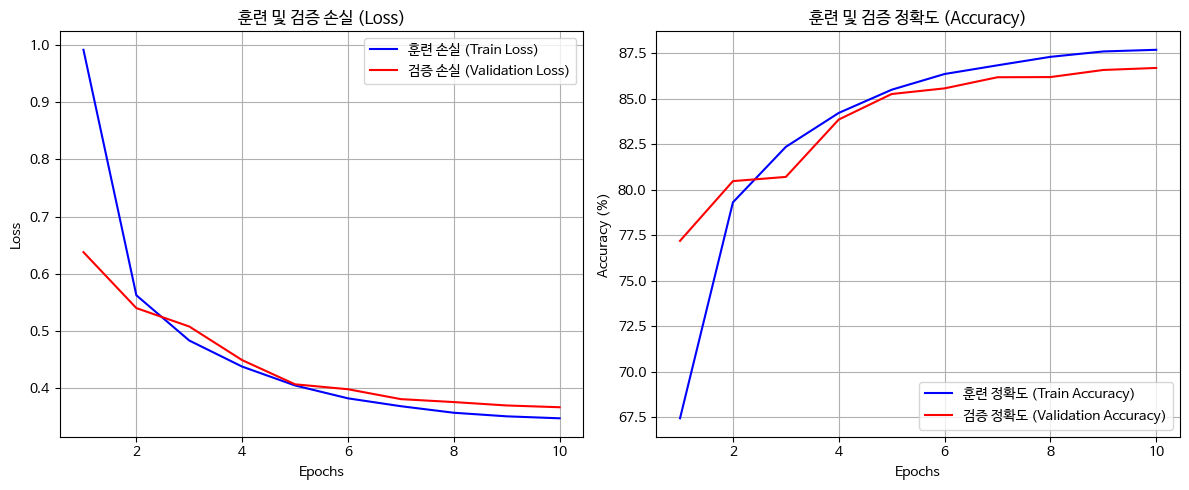

In [14]:
def plot_history(history):
    # 에포크(Epoch) 수
    epochs = range(1, len(history['train_loss']) + 1)

    # 1. 손실 (Loss) 그래프
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b', label='훈련 손실 (Train Loss)')
    plt.plot(epochs, history['val_loss'], 'r', label='검증 손실 (Validation Loss)')
    plt.title('훈련 및 검증 손실 (Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # 2. 정확도 (Accuracy) 그래프
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b', label='훈련 정확도 (Train Accuracy)')
    plt.plot(epochs, history['val_acc'], 'r', label='검증 정확도 (Validation Accuracy)')
    plt.title('훈련 및 검증 정확도 (Accuracy)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# 시각화 함수 호출
plot_history(history)

모델 예측 결과 vs. 실제 정답 비교:


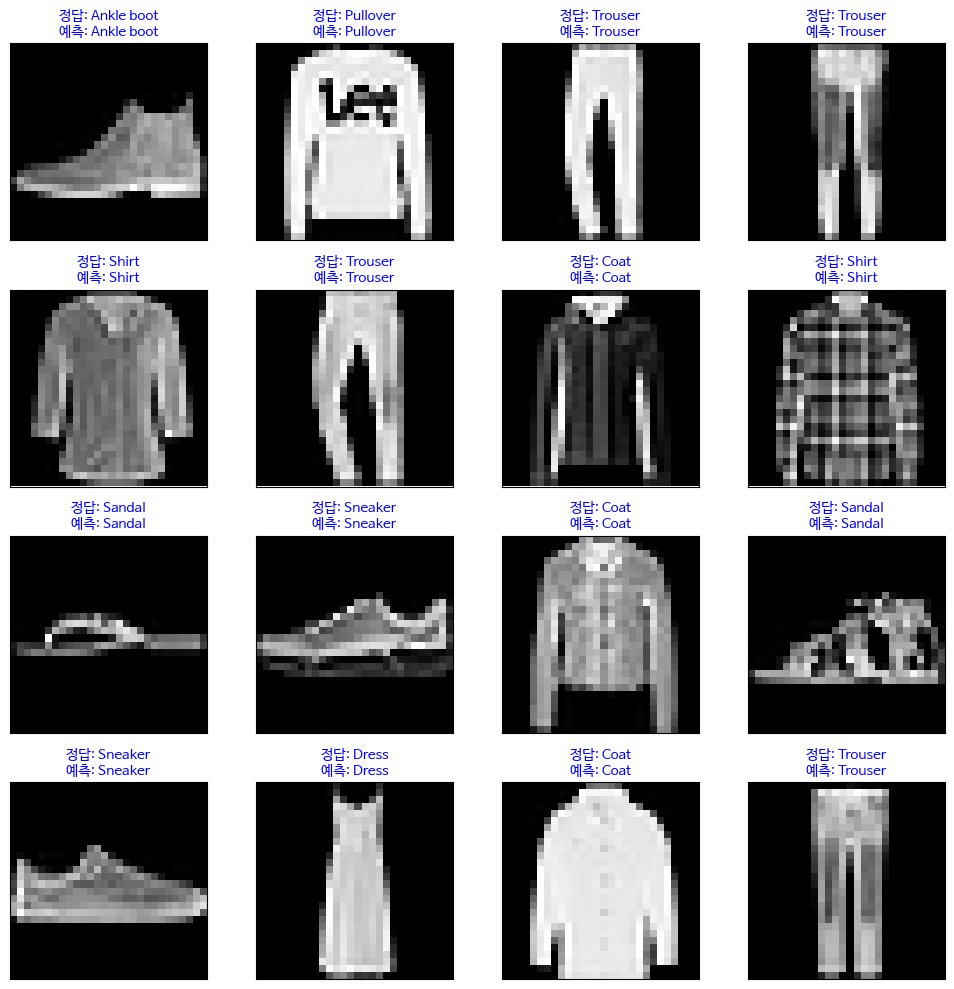

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

def visualize_predictions(model, dataloader, class_names, num_images=16, device='cpu'):

    model.eval() # 모델을 평가 모드로 설정
    images_shown = 0
    fig = plt.figure(figsize=(10, 10))

    # 정규화 역변환을 위한 설정
    mean = np.array([0.5])
    std = np.array([0.5])

    with torch.no_grad(): # 기울기 계산 비활성화 (메모리 절약 및 속도 향상)
        for images, labels in dataloader:
            if images_shown >= num_images:
                break

            images = images.to(device)

            # 1. 모델 예측 수행
            outputs = model(images)
            # 가장 높은 확률을 가진 클래스의 인덱스를 가져옵니다.
            _, predicted = torch.max(outputs, 1)

            for i in range(len(images)):
                if images_shown >= num_images:
                    break

                # 시각화 설정
                ax = fig.add_subplot(4, 4, images_shown + 1, xticks=[], yticks=[])

                # 2. 이미지 처리 및 역변환
                image_np = images[i].cpu().numpy().transpose((1, 2, 0)) # C, H, W -> H, W, C
                image_np = image_np * std + mean
                image_np = np.clip(image_np, 0, 1)

                # 3. 예측값 및 정답 레이블 정의
                true_label = class_names[labels[i].item()]
                predicted_label = class_names[predicted[i].item()]

                is_correct = (predicted[i] == labels[i]).item()

                # 4. 제목 설정 (색상으로 맞춤/틀림 표시)
                title_text = f"정답: {true_label}\n예측: {predicted_label}"
                color = 'blue' if is_correct else 'red'

                # 5. 이미지 출력
                ax.imshow(image_np.squeeze(), cmap='gray')
                ax.set_title(title_text, color=color, fontsize=10)

                images_shown += 1

    plt.tight_layout()
    plt.show()

# --- 실행 부분 ---
# device 변수가 정의되어 있다고 가정
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# 예시: 검증 데이터에서 16개 샘플 시각화
print("모델 예측 결과 vs. 실제 정답 비교:")
visualize_predictions(model, val_loader, class_names, num_images=16, device=device)